In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**MINGGU 1 = MEMPERBAIKI STRUKTUR DATASET**

In [14]:
import os
import shutil

BASE = "/content/drive/MyDrive/datasetviskom/datasetviskom"

splits = ["train", "validation", "test"]

for split in splits:
    path = os.path.join(BASE, split)
    print("\nMemperbaiki folder:", path)

    # cari folder potato dan tomato
    for class_folder in ["potato", "tomato"]:
        parent = os.path.join(path, class_folder)

        if os.path.exists(parent):
            print("Ditemukan folder:", parent)

            # pindahkan semua subfolder (6 kelas) ke level atas
            for sub in os.listdir(parent):
                old = os.path.join(parent, sub)
                new = os.path.join(path, sub)
                print("Memindahkan:", old, "→", new)
                shutil.move(old, new)

            # hapus folder potato/ tomato
            print("Menghapus:", parent)
            shutil.rmtree(parent)

print("\n⭐⭐ Struktur dataset sudah diperbaiki!")



Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/train

Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/validation

Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/test

⭐⭐ Struktur dataset sudah diperbaiki!


In [8]:
!ls /content/drive/MyDrive/datasetviskom/datasetviskom/train


potato_early_blight  potato_late_blight   tomato_healthy
potato_healthy	     tomato_early_blight  tomato_late_blight


**MINGGU 2 = PREPROCESSING**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# ==========================
# PATH DATASET YANG BENAR
# ==========================
DATA_DIR = "/content/drive/MyDrive/datasetviskom/datasetviskom"

train_dir = DATA_DIR + "/train"
val_dir   = DATA_DIR + "/validation"
test_dir  = DATA_DIR + "/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ==========================
# LOAD DATASET
# ==========================
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

class_names = train_ds.class_names
print("Classes:", class_names)

# ==========================
# NORMALIZATION
# ==========================
normalization = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization(x), y))

# ==========================
# DATA AUGMENTATION
# ==========================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# ==========================
# PREFETCH (lebih cepat)
# ==========================
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

print("Preprocessing Minggu 2 SELESAI!")


Found 4792 files belonging to 6 classes.
Found 1196 files belonging to 6 classes.
Found 664 files belonging to 6 classes.
Classes: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']
Preprocessing Minggu 2 SELESAI!


**MINGGU 3 = TRAINING & TUNING**

In [14]:
class_names = [
    'potato_early_blight',
    'potato_healthy',
    'potato_late_blight',
    'tomato_early_blight',
    'tomato_healthy',
    'tomato_late_blight'
]

num_classes = len(class_names)


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)

base = keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False   # tahap 1 freeze


In [16]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)


**TRAINING 2**

Jumlah kelas: 6
Nama kelas: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.2462 - loss: 1.7696 - val_accuracy: 0.3579 - val_loss: 1.6418
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.2706 - loss: 1.6603 - val_accuracy: 0.2868 - val_loss: 1.6409
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.2858 - loss: 1.6581 - val_accuracy: 0.2860 - val_loss: 1.6410
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.2761 - loss: 1.6571 - val_accuracy: 0.2868 - val_loss: 1.6376
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.2926 - loss: 1.6536 - val_accuracy: 0.2868 - val_loss: 1.6383
21/21 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.2674 - loss: 1.6524

=== HASIL AKHIR MINGGU 3 ===
Test Accuracy : 0.28614458441734314
Test Loss     : 1.6385968923568726

Model disimpan di: /content/drive/MyDrive/model_mobilenetv2_leaf_final.keras


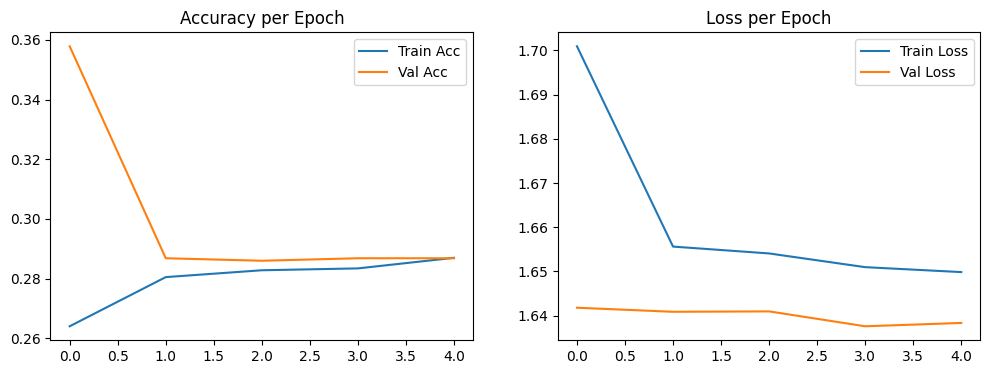

In [22]:
# ===========================================
# MINGGU 3 — TRAINING & TUNING (FIXED)
# ===========================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import json

# Dataset sudah ada dari Minggu 2:
# train_ds, val_ds, test_ds, class_names

print("Jumlah kelas:", len(class_names))
print("Nama kelas:", class_names)

# Optimasi pipeline
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# -------------------------------------------
# 1. MobileNetV2 dengan ukuran input 224 (COCOK dataset!)
# -------------------------------------------

IMG_SIZE = (224, 224)

base = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base.trainable = False   # Feature extraction

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------------------------
# 2. TRAINING Cepat (5 epoch)
# -------------------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# -------------------------------------------
# 3. Evaluasi
# -------------------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("\n=== HASIL AKHIR MINGGU 3 ===")
print("Test Accuracy :", test_acc)
print("Test Loss     :", test_loss)

# -------------------------------------------
# 4. Save model & class names
# -------------------------------------------
save_path = "/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras"
model.save(save_path)

with open("/content/drive/MyDrive/model_mobilenetv2_classes.json", "w") as f:
    json.dump(class_names, f)

print("\nModel disimpan di:", save_path)

# -------------------------------------------
# 5. Grafik akurasi & loss
# -------------------------------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.show()


In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json


In [24]:
# Load trained model
model = keras.models.load_model("/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras")

# Load class names
with open("/content/drive/MyDrive/model_mobilenetv2_leaf_classes.json", "r") as f:
    class_names = json.load(f)

print("Class names:", class_names)


Class names: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']


In [25]:
test_dir = "/content/drive/MyDrive/datasetviskom/datasetviskom/test"

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(160, 160),
    batch_size=32,
    label_mode="categorical",
    shuffle=False
)


Found 664 files belonging to 6 classes.


In [27]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

# Load model final
model = keras.models.load_model("/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras")

# Load class names
with open("/content/drive/MyDrive/model_mobilenetv2_leaf_classes.json", "r") as f:
    class_names = json.load(f)

print("Kelas:", class_names)


Kelas: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']


In [28]:
def predict_leaf(image_path):
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize((224, 224))

    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)[0]

    pred_index = np.argmax(preds)
    confidence = preds[pred_index]

    predicted_class = class_names[pred_index]

    # Tentukan status
    if "healthy" in predicted_class.lower():
        status = "SEHAT"
    else:
        status = "TERINFEKSI"

    # Tampilkan gambar
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    print("=== HASIL PREDIKSI ===")
    print("Status:", status)
    print("Jenis:", predicted_class.replace("_", " ").title())
    print(f"Confidence: {confidence:.3f}")


In [30]:
from google.colab import files
uploaded = files.upload()


Saving tomat3.jpg to tomat3.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
=== HASIL PREDIKSI ===
Status: TERINFEKSI
Jenis: Tomato Late Blight
Confidence: 0.279


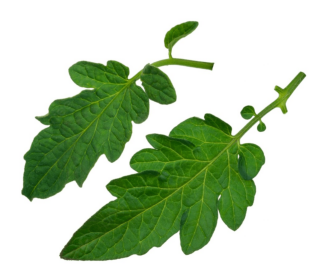

In [31]:
predict_leaf("/content/tomat3.jpg")


Fine Tuning

In [26]:
# BUKA BLOK FEATURE EXTRACTION
base.trainable = True

# Freeze semua layer kecuali 40 terakhir
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer = keras.optimizers.Adam(1e-5),   # learning rate kecil untuk fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 95s 535ms/step - accuracy: 0.7959 - loss: 0.5532 - val_accuracy: 0.3127 - val_loss: 3.2032
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.7934 - loss: 0.5431 - val_accuracy: 0.4064 - val_loss: 3.2261
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 448ms/step - accuracy: 0.7896 - loss: 0.5439 - val_accuracy: 0.4047 - val_loss: 3.4160
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.7898 - loss: 0.5228 - val_accuracy: 0.3997 - val_loss: 3.2340
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.7944 - loss: 0.5294 - val_accuracy: 0.3988 - val_loss: 3.0834
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.7855 - loss: 0.5373 - val_accuracy: 0.4197 - val_loss: 2.7719
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.7882 - loss: 0.5334 - val_accuracy: 0.4339 - val_loss: 2.2648
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.8028 - loss: 0

**MINGGU KEEMPAT = TESTING MODEL, ANALISIS HASIL, DAN DOKUMENTASI FINAL**

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(class_names)

# ============================
# Bangun Model MobileNetV2
# ============================
base = keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False   # Tahap 1 freeze backbone

inputs = keras.Input(shape=(224,224,3))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ============================
# CHECKPOINT setiap 5 epoch
# ============================
ckpt_path = "/content/drive/MyDrive/checkpoint_epoch_{epoch:02d}.keras"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_freq='epoch',
    save_best_only=False,
)

# ============================
# TRAINING HEAD (10 epoch)
# ============================
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt]
)

print("Tahap 1 selesai — checkpoint tersimpan setiap 5 epoch.")


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 511ms/step - accuracy: 0.1907 - loss: 2.0067 - val_accuracy: 0.2868 - val_loss: 1.6417
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 440ms/step - accuracy: 0.2282 - loss: 1.7798 - val_accuracy: 0.3453 - val_loss: 1.6382
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 435ms/step - accuracy: 0.2341 - loss: 1.7571 - val_accuracy: 0.2893 - val_loss: 1.6350
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 435ms/step - accuracy: 0.2330 - loss: 1.7554 - val_accuracy: 0.3629 - val_loss: 1.6325
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 439ms/step - accuracy: 0.2542 - loss: 1.7436 - val_accuracy: 0.3863 - val_loss: 1.6317

Model berhasil disimpan sebagai: /content/drive/MyDrive/model_mobilenetv2_leaf_final.keras
Class names saved.


In [32]:
from tensorflow import keras
import json

model = keras.models.load_model("/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras")

with open("/content/drive/MyDrive/model_mobilenetv2_leaf_classes.json") as f:
    class_names = json.load(f)

print("Model loaded!")
print("Classes:", class_names)


Model loaded!
Classes: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']


In [33]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.3758 - loss: 1.6350
Test Accuracy: 0.379518061876297
Test Loss: 1.6331809759140015


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


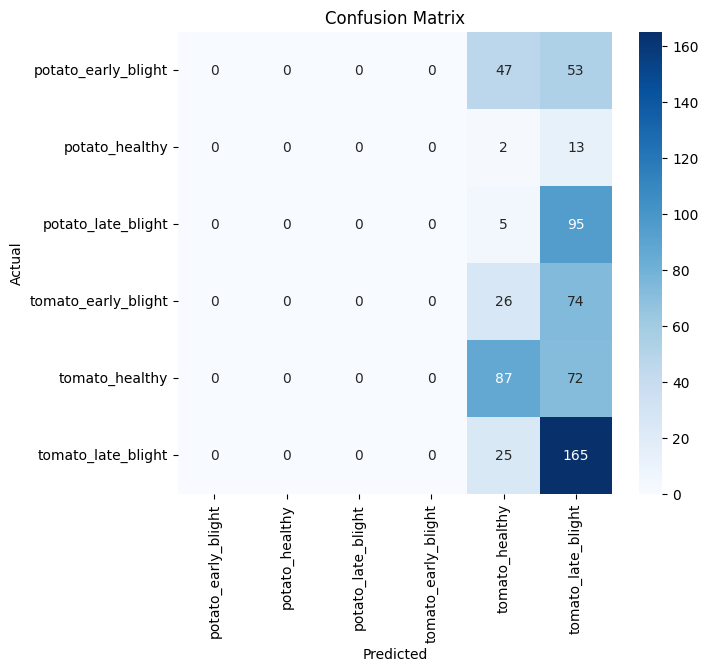


Classification Report:
                     precision    recall  f1-score   support

potato_early_blight       0.00      0.00      0.00       100
     potato_healthy       0.00      0.00      0.00        15
 potato_late_blight       0.00      0.00      0.00       100
tomato_early_blight       0.00      0.00      0.00       100
     tomato_healthy       0.45      0.55      0.50       159
 tomato_late_blight       0.35      0.87      0.50       190

           accuracy                           0.38       664
          macro avg       0.13      0.24      0.17       664
       weighted avg       0.21      0.38      0.26       664



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def predict_leaf(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)

    arr = np.expand_dims(img_resized / 255.0, axis=0)

    pred = model.predict(arr)[0]
    idx = np.argmax(pred)
    label = class_names[idx]
    confidence = pred[idx]

    # Status sehat / penyakit
    status = "SEHAT" if "healthy" in label else "TERINFEKSI"

    plt.imshow(img)
    plt.axis("off")
    plt.title("Gambar Uji")
    plt.show()

    print("=== HASIL PREDIKSI ===")
    print("Status:", status)
    print("Kelas Prediksi:", label.replace("_", " ").title())
    print("Confidence:", round(float(confidence), 3))


Saving tomat3.jpg to tomat3.jpg

Menguji: tomat3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


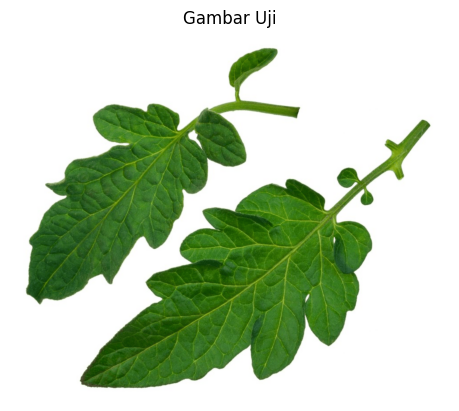

=== HASIL PREDIKSI ===
Status: TERINFEKSI
Kelas Prediksi: Tomato Late Blight
Confidence: 0.278


In [36]:
from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    print("\nMenguji:", fname)
    predict_leaf(fname)
